In [2]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import brainspace.gradient
import brainspace.mesh
import brainspace.plotting
import nilearn.plotting
import nilearn.datasets
import nibabel
import os
from IPython.display import display, Markdown, Latex

# Week 7 & 8

# Load data

In [3]:
scipy.io.loadmat('data_week7.mat')['data'].dtype

dtype([('dti', 'O'), ('mpc', 'O'), ('rsfc', 'O'), ('parcels', 'O'), ('surf', 'O')])

In [188]:
parcels_map = scipy.io.loadmat('data_week7.mat')['data'][0,0][3][0]

In [198]:
matrices = {}
matrices['dti'] = scipy.io.loadmat('data_week7.mat')['data'][0,0][0]
matrices['mpc'] = scipy.io.loadmat('data_week7.mat')['data'][0,0][1]
matrices['rsfc'] = scipy.io.loadmat('data_week7.mat')['data'][0,0][2]

Plot the matrices

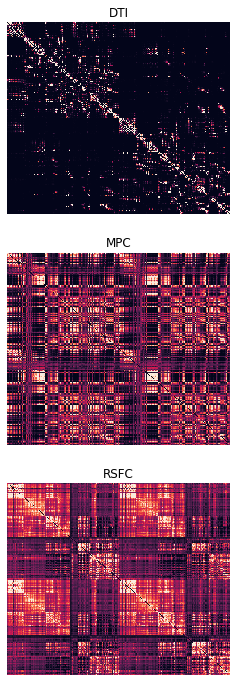

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(4, 12))
for i, (key, mat) in enumerate(matrices.items()):
    sns.heatmap(
        mat, 
        vmin=np.quantile(mat.flatten(),0.025),
        vmax=np.quantile(mat.flatten(),0.975),
        ax=axes[i], 
        cbar=False)
    axes[i].axis('off')
    axes[i].set_title(key.upper())

# Gradients

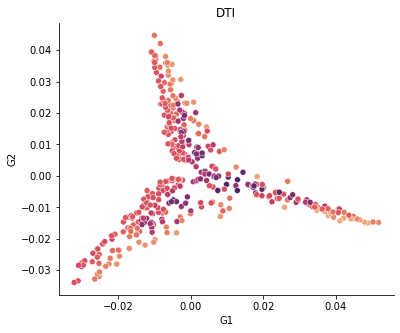

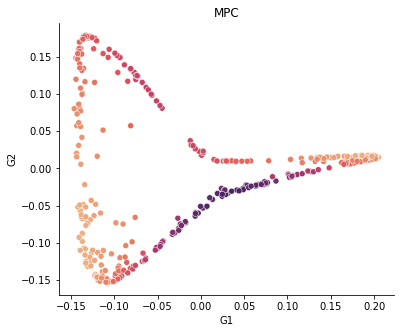

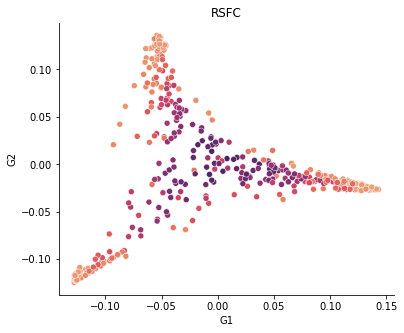

In [199]:
gms = {}
gradients = {}
n_gradients = 3
for name, mat in matrices.items():
    gms[name] = brainspace.gradient.GradientMaps(
                    n_components=n_gradients, 
                    approach='dm', 
                    kernel='normalized_angle', 
                    random_state=912
                ).fit(
                    mat,
                    sparsity=0.9
                )
    gradients[name] = gms[name].gradients_
    fig, ax = plt.subplots(figsize=(6,5));
    ax = sns.scatterplot(x=gradients[name][:,0], y=gradients[name][:,1], hue=gradients[name][:,2], palette=sns.color_palette("flare", as_cmap=True), legend=False, ax=ax);
    ax.set_xlabel('G1');
    ax.set_ylabel('G2');
    ax.set_title(name.upper())
#     ax.set_xticks([]);
#     ax.set_yticks([]);
    ax.spines['right'].set_visible(False);
    ax.spines['top'].set_visible(False);

Project to surface

In [191]:
def project_sch400_to_surf(parcellated_data):
    all_parcels = list(range(1, 202)) + list(range(1001, 1202))
    valid_parcels = list(range(2, 202)) + list(range(1002, 1202))
    surf_map = (
        pd.concat([
            pd.DataFrame(parcellated_data, index=valid_parcels),
            pd.Series(0, index=all_parcels, name='dummy')
        ], axis=1)
        .loc[parcels_map]
        .drop(columns=['dummy'])
        .values
    )
    if surf_map.shape[1] == 1:
        surf_map = surf_map.flatten()
    return surf_map

gradients_surface = {}
for name in gradients.keys():
    gradients_surface[name] = project_sch400_to_surf(gradients[name])

Plot on surface

In [10]:
fsaverage5 = nilearn.datasets.fetch_surf_fsaverage('fsaverage5')
lh_surf = brainspace.mesh.mesh_io.read_surface(fsaverage5['pial_left'])
rh_surf = brainspace.mesh.mesh_io.read_surface(fsaverage5['pial_right'])

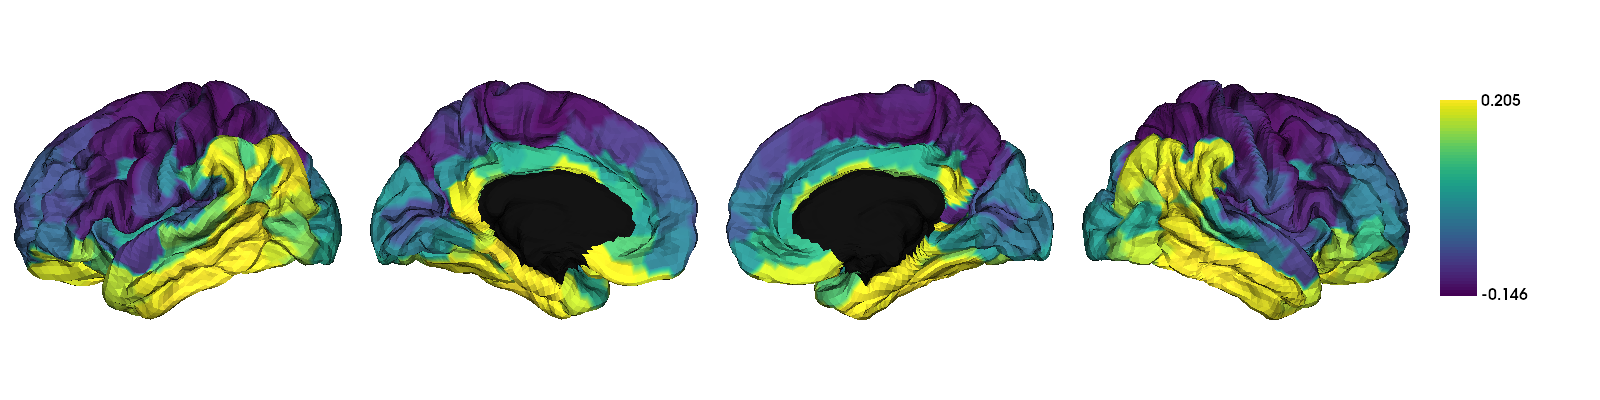

In [11]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, gradients_surface['mpc'][:, 0],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

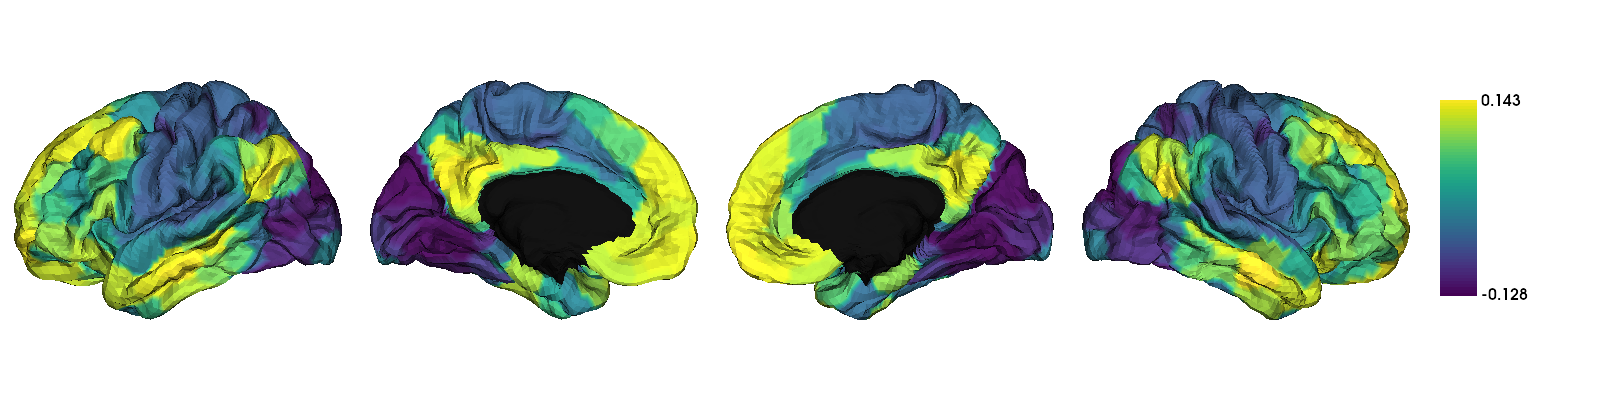

In [12]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, gradients_surface['rsfc'][:, 0],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

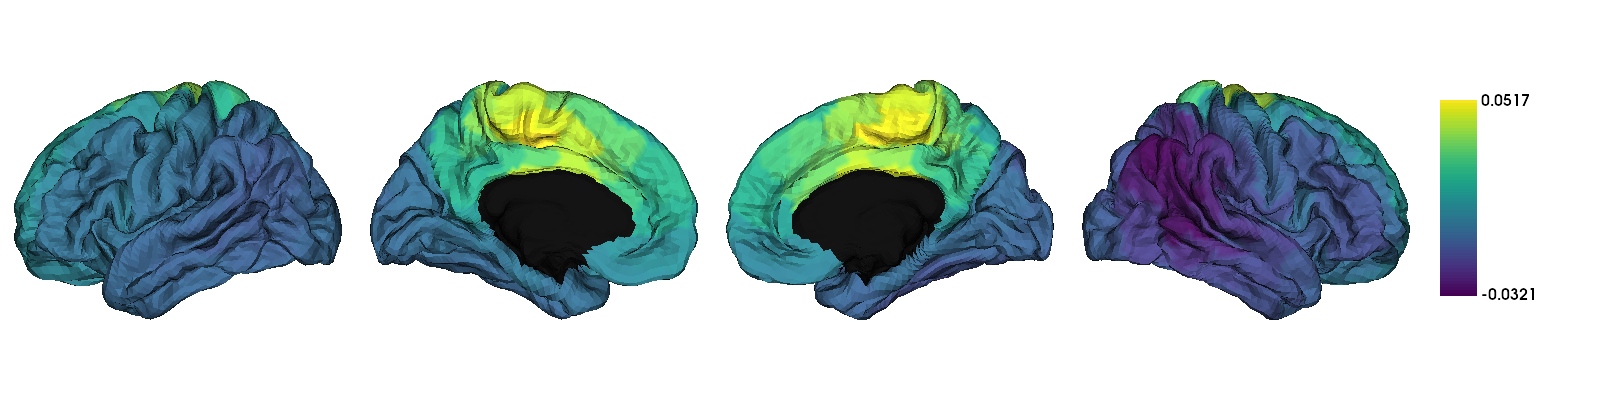

In [13]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, gradients_surface['dti'][:, 0],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

# Graph Theory Measures

In [14]:
import bct

<AxesSubplot:>

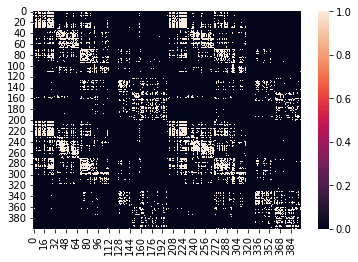

In [81]:
rsfc_wei = bct.threshold_proportional(matrices['rsfc'], 0.1)
rsfc_bin = bct.binarize(
    rsfc_wei
)
sns.heatmap(rsfc_bin)

<AxesSubplot:>

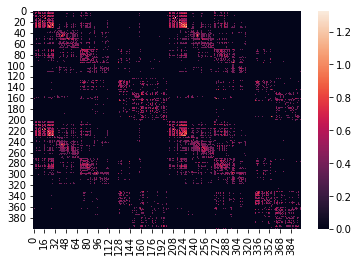

In [82]:
sns.heatmap(rsfc_wei)

In [77]:
# degree = bct.degrees_und(rsfc_bin)
# degree_wei = bct.degrees_und(rsfc_wei)
degree = rsfc_bin.sum(axis=1)
degree_wei = rsfc_wei.sum(axis=1)

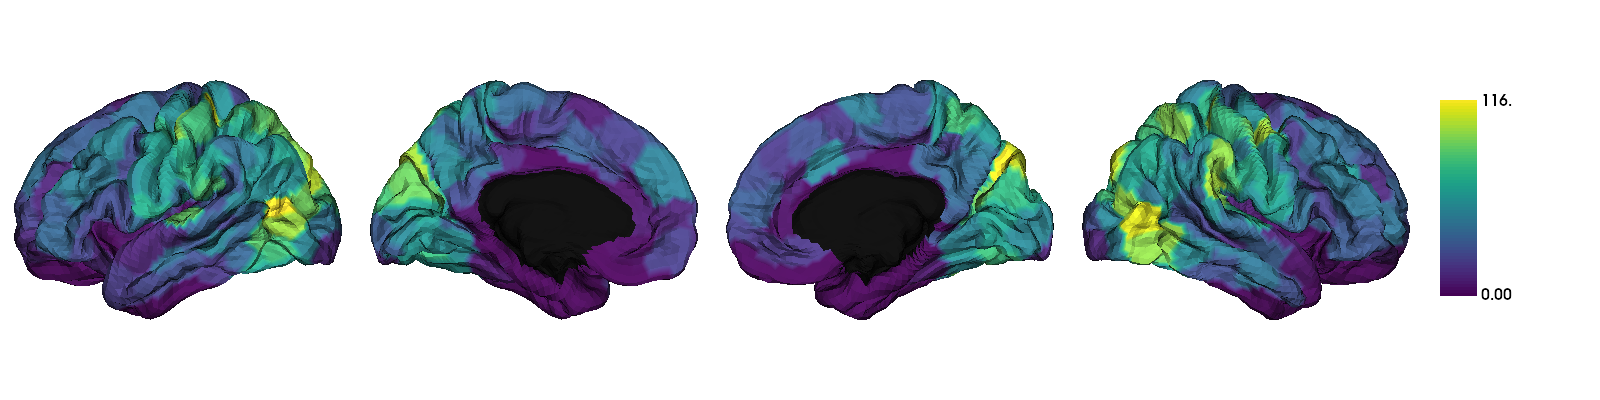

In [78]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(degree),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

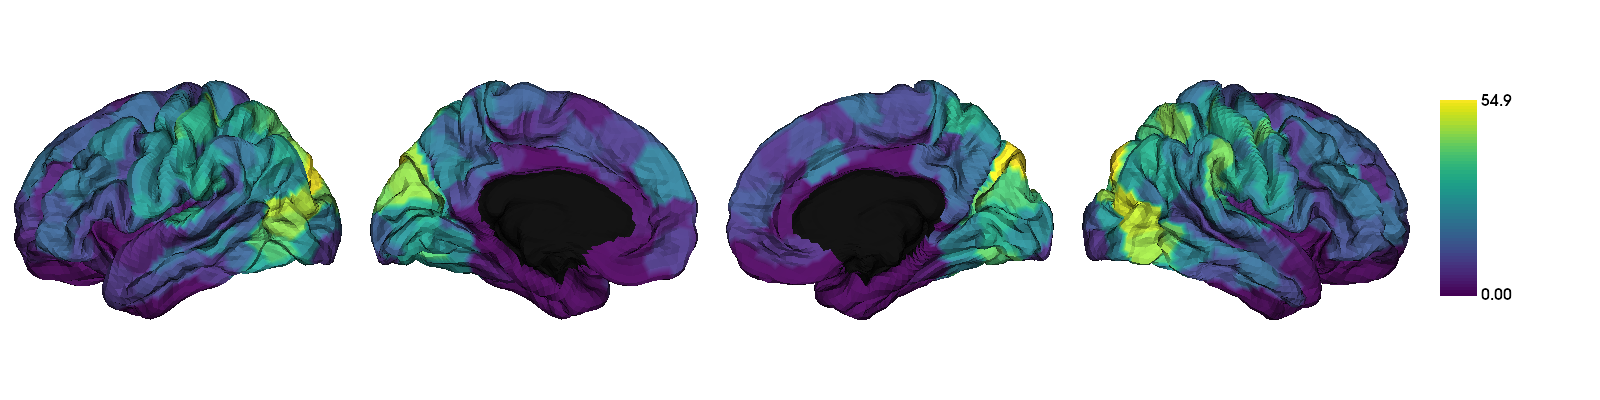

In [79]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(degree_wei),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

<AxesSubplot:>

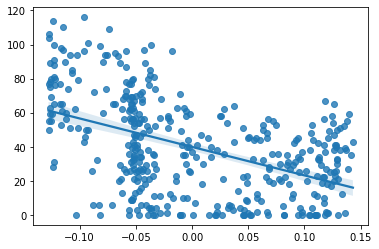

In [67]:
sns.regplot(
    x = gradients['rsfc'][:, 0],
    y = degree
)

In [69]:
scipy.stats.pearsonr(
    x = gradients['rsfc'][:, 0],
    y = degree
)

(-0.4709329659826284, 1.7974196346658273e-23)

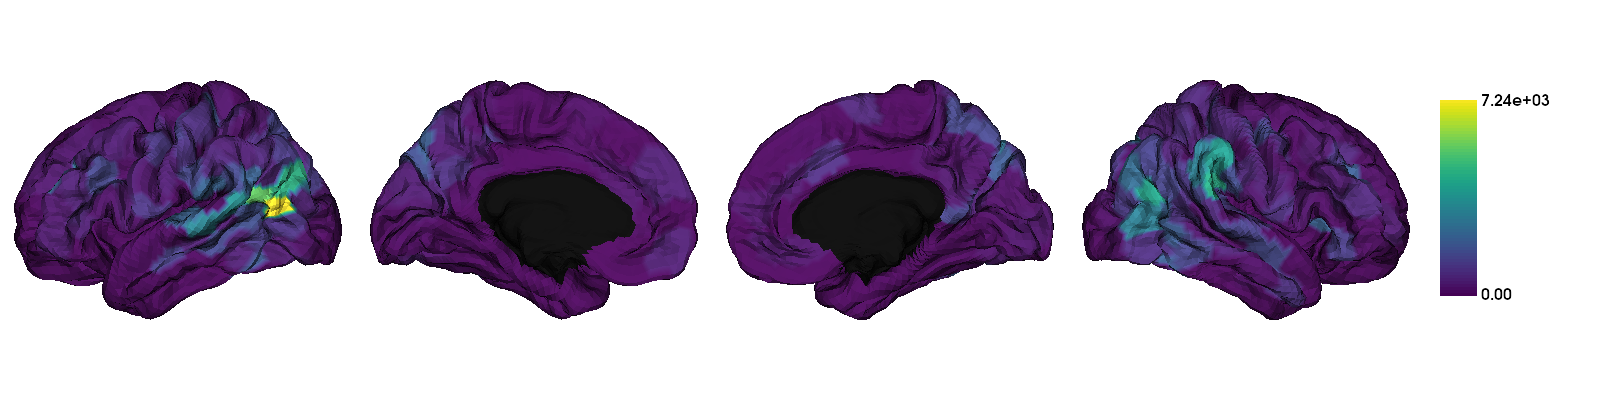

In [18]:
betweenness = bct.betweenness_bin(rsfc_bin)
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(betweenness),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

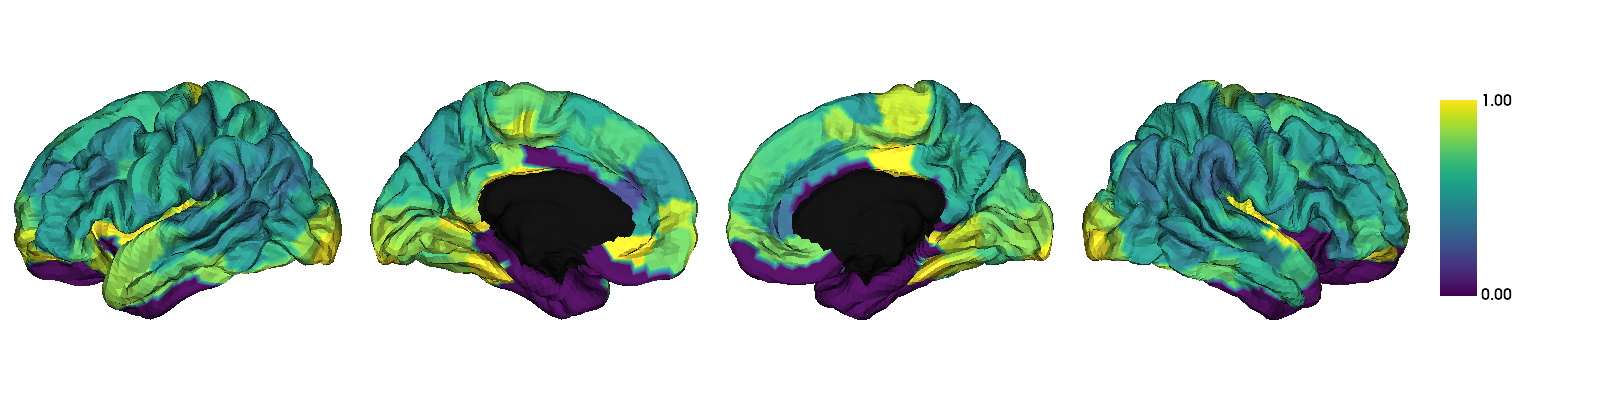

In [19]:
clustering_coef = bct.clustering_coef_bu(rsfc_bin)
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(clustering_coef),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

In [20]:
bct.get_components(rsfc_bin)

(array([34, 34, 34, 34, 34, 34,  1, 34, 34, 34, 34, 34,  2, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,  3, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,  4,  5,  6,  7, 34,  8,
         9, 10, 11, 12, 34, 13, 14, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 15, 34, 34, 16, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 17, 34, 34, 34, 34, 34, 34,
        34, 34, 18, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 

Maximized modularity metric: 0.4651080944843312


/Users/a.saberi/opt/miniconda3/envs/sci/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


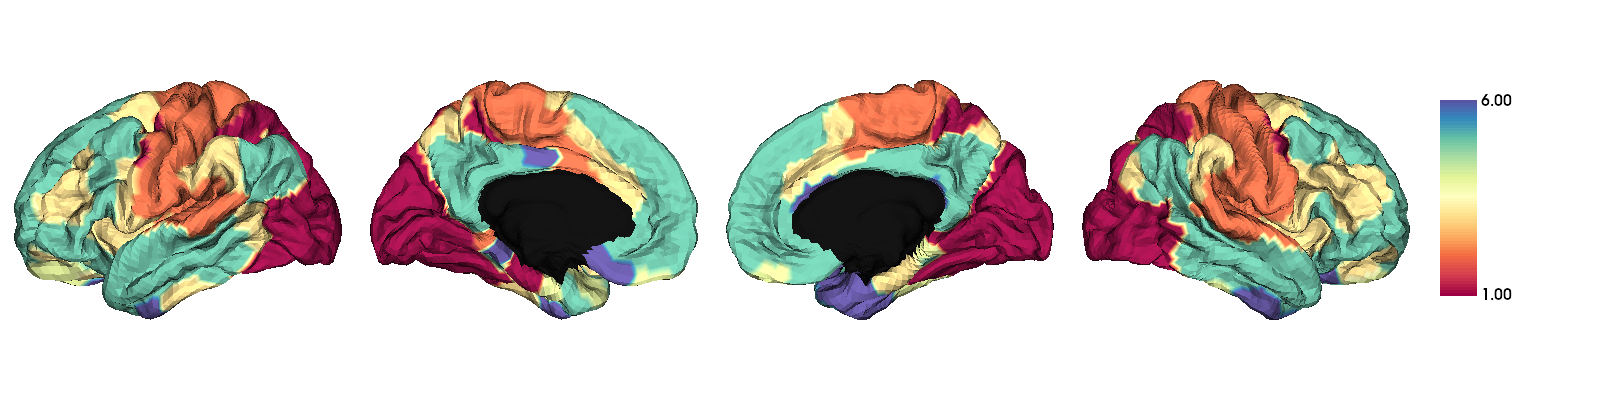

In [21]:
modules, modularity_Q = bct.modularity_und(rsfc_bin)
print("Maximized modularity metric:", modularity_Q)
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(modules),
    cmap='Spectral',
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

/Users/a.saberi/opt/miniconda3/envs/sci/lib/python3.9/site-packages/bct/algorithms/centrality.py:661: RuntimeWarning: invalid value encountered in true_divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


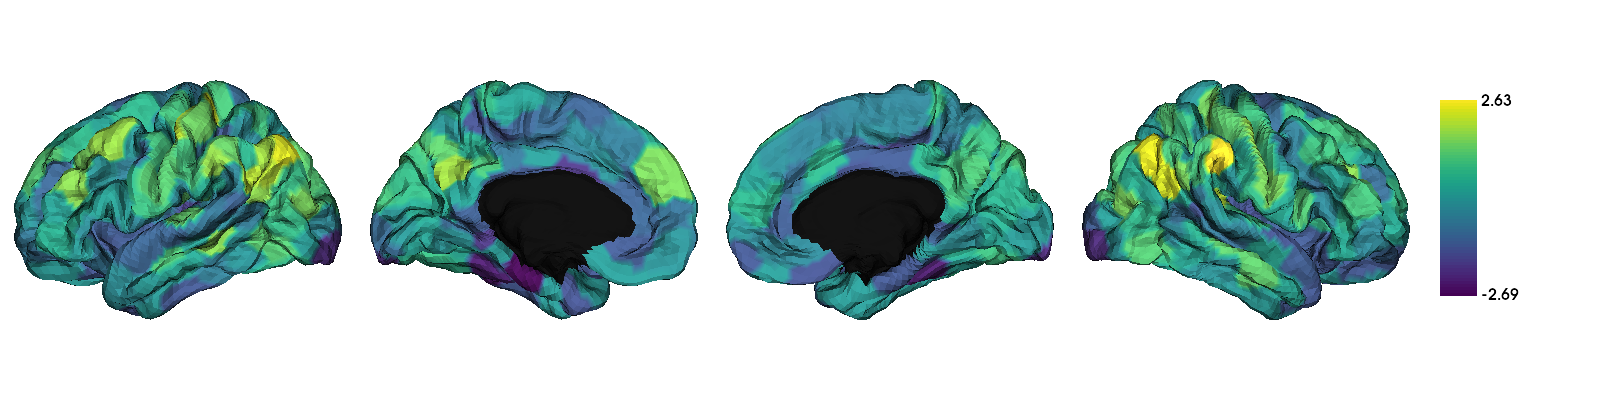

In [53]:
module_degree_zscore = bct.module_degree_zscore(rsfc_bin, modules)
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(module_degree_zscore),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

/Users/a.saberi/opt/miniconda3/envs/sci/lib/python3.9/site-packages/bct/algorithms/centrality.py:760: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


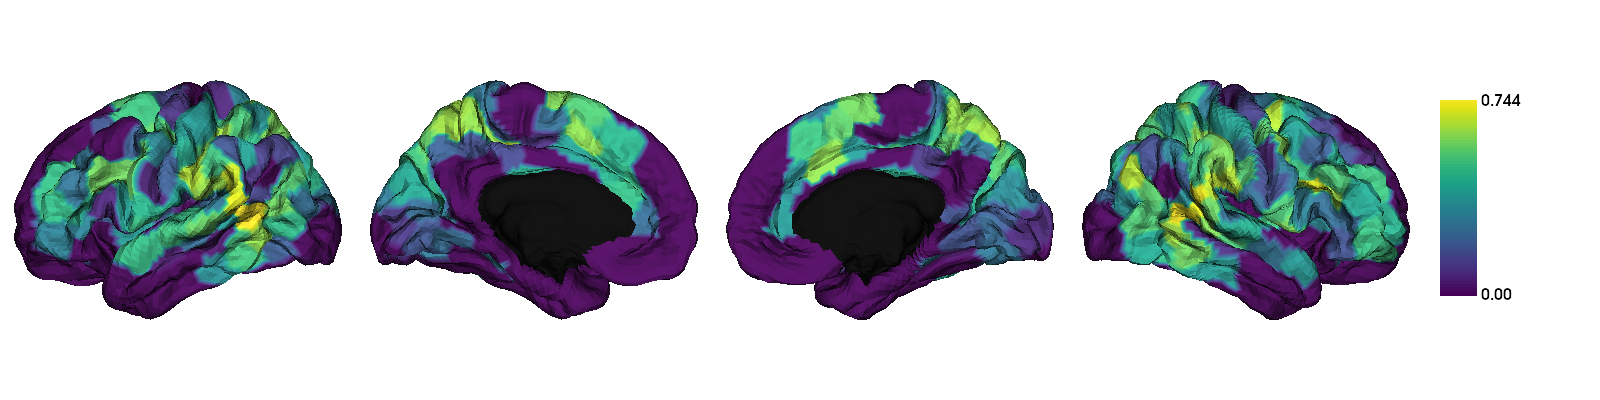

In [54]:
participation_coef = bct.participation_coef(rsfc_bin, modules)
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(participation_coef),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

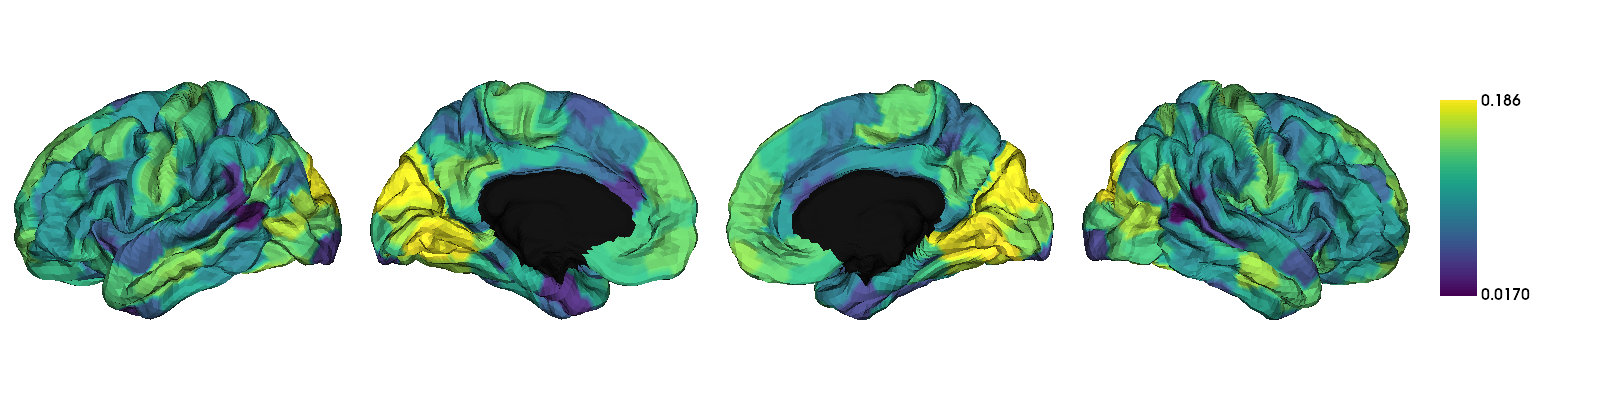

In [65]:
gradient_eccentricity = scipy.spatial.distance_matrix(gradients['rsfc'], np.array([[0, 0, 0]])).flatten()
brainspace.plotting.surface_plotting.plot_hemispheres(
    lh_surf, rh_surf, 
    project_sch400_to_surf(gradient_eccentricity),
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

In [22]:
bct.assortativity_bin(rsfc_bin)

0.29155756792608883

In [23]:
bct.efficiency_bin(rsfc_bin)

0.39395634920634914

In [26]:
mean_parcel_coords = (pd.DataFrame(
    np.concatenate([
        nilearn.surface.load_surf_mesh(fsaverage5['pial_left']).coordinates,
        nilearn.surface.load_surf_mesh(fsaverage5['pial_right']).coordinates,
    ]),  index=parcels_map
)
 .reset_index().groupby('index').mean()
 .drop(index=[1, 1001]).values
)

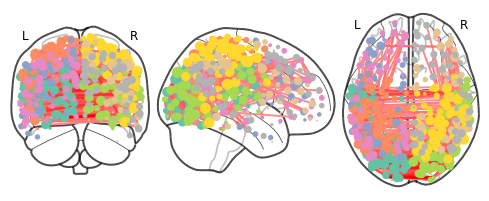

In [31]:
nilearn.plotting.plot_connectome(bct.threshold_proportional(matrices['rsfc'], 0.01), mean_parcel_coords, node_size=degree)

In [24]:
# null_graphs = np.empty((400, 400, 100))
# for idx in range(100):
#     print(idx)
#     null_graphs[:, :, idx], _ = bct.randmio_und(rsfc_bin, 3)

# Week 9

- Creating the structural covariance matrix using the data from brainstat
- Gradients and graph thoery measures on covariance matrix

In [1]:
!pip install brainstat

     |████████████████████████████████| 945 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 757 kB 56.5 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 6.7 MB/s eta 0:00:011
     |████████████████████████████████| 13.3 MB 12.2 MB/s eta 0:00:01    |███████████████████████▍        | 9.7 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 6.0 MB/s eta 0:00:01
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
     |████████████████████████████████| 2.3 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 4.7 MB/s eta 0:00:011
     |████████████████████████████████| 6.2 MB 17.1 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 43.4 MB/s eta 0:00:01
     |████████████████████████████████| 532 kB 17.9 MB/s eta 0:00:01
  Created wheel for neurosynth: filename=neurosynth-0.3.8-py2.py3-none-any.whl size=554087 sha256=203eac47293d9a217e06c5a4d8b0

In [1]:
## Structural covariance matrix

Loading the data

In [192]:
from brainstat.datasets import fetch_mask, fetch_template_surface, fetch_parcellation
from brainstat.tutorial.utils import fetch_mics_data

thickness, demographics = fetch_mics_data()
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
sch400 = fetch_parcellation("fsaverage5", "schaefer", 400)

In [193]:
thickness.shape

(82, 20484)

In [194]:
demographics

SUB_ID  VISIT  AGE_AT_SCAN SEX
0   031404      1           27   F
1   04a144      1           25   M
2   0b78f1      1           33   M
3   0d26b9      1           36   F
4   1988b8      1           31   M
..     ...    ...          ...  ..
77  f25714      1           30   F
78  f25714      2           33   F
79  f615a5      1           26   F
80  feac6b      1           26   F
81  feac6b      2           29   F

[82 rows x 4 columns]

Selecting only visit 1:

In [7]:
demographics_v1 = demographics[demographics['VISIT']==1]

In [12]:
thickness_v1 = thickness[demographics_v1.index, :]

Parcellation:

In [162]:
thickness_v1_sch400 = (
    pd.concat([
        pd.DataFrame(thickness_v1.T),
        pd.Series(sch400, name='sch400')
    ], axis = 1)
    [mask]
    .groupby('sch400')
    .mean()
    .T
)

In [163]:
thickness_v1_sch400.shape

(70, 400)

In [164]:
X = pd.DataFrame({
    'intercept': 1,
    'AGE_AT_SCAN': demographics_v1.AGE_AT_SCAN,
    'FEMALE': (demographics_v1.SEX=='F').astype('int'),
    'GLOBAL_THICKNESS': thickness_v1_sch400.mean(axis=1),
})
Y = thickness_v1_sch400.values

In [113]:
X

intercept  AGE_AT_SCAN  FEMALE  GLOBAL_THICKNESS
0           1           27       1          2.259400
1           1           25       0          2.502191
2           1           33       0          2.396895
3           1           36       1          2.378286
4           1           31       0          2.447867
..        ...          ...     ...               ...
74          1           31       0          2.507647
76          1           30       0          2.482112
77          1           30       1          2.497584
79          1           26       1          2.391663
80          1           26       1          2.539182

[70 rows x 4 columns]

In [136]:
betas = np.linalg.inv(X.values.T @ X.values) @ X.values.T @ Y

In [140]:
resid = Y - (X @ betas)

In [141]:
my_SC_matrix = np.corrcoef(resid.T)

Text(0.5, 1.0, 'Structural Covariance')

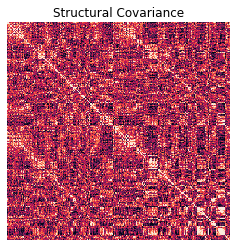

In [142]:
fig, ax = plt.subplots(1, figsize=(4, 4))
sns.heatmap(
    my_SC_matrix, 
    vmin=np.quantile(my_SC_matrix.flatten(),0.025),
    vmax=np.quantile(my_SC_matrix.flatten(),0.975),
    ax=ax,
    cbar=False)
ax.axis('off')
ax.set_title('Structural Covariance')

Without regressing out global thickness:

In [143]:
X = pd.DataFrame({
    'intercept': 1,
    'AGE_AT_SCAN': demographics_v1.AGE_AT_SCAN,
    'FEMALE': (demographics_v1.SEX=='F').astype('int'),
})
betas = np.linalg.inv(X.values.T @ X.values) @ X.values.T @ Y
resid = Y - (X @ betas)
my_SC_matrix_no_gt = np.corrcoef(resid.T)

Text(0.5, 1.0, 'Structural Covariance (without regressing out global thickness)')

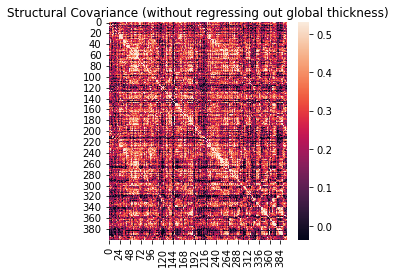

In [206]:
fig, ax = plt.subplots(1, figsize=(4, 4))
sns.heatmap(
    my_SC_matrix_no_gt, 
    vmin=np.quantile(my_SC_matrix_no_gt.flatten(),0.025),
    vmax=np.quantile(my_SC_matrix_no_gt.flatten(),0.975),
    ax=ax,
    cbar=True)
# ax.axis('off')
ax.set_title('Structural Covariance (without regressing out global thickness)')

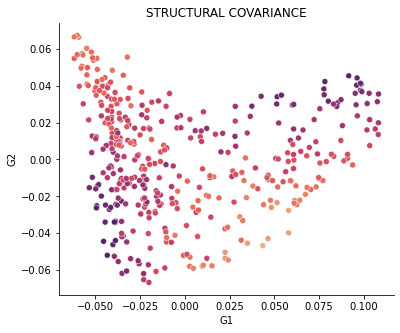

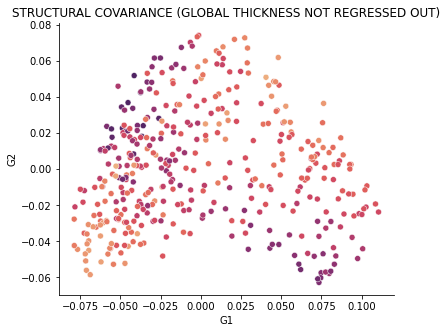

In [200]:
sc_matrices = {
    'Structural covariance': my_SC_matrix,
    'Structural covariance (global thickness not regressed out)': my_SC_matrix_no_gt
}
matrices.update(sc_matrices)

for name, mat in sc_matrices.items():
    gms[name] = brainspace.gradient.GradientMaps(
                    n_components=n_gradients, 
                    approach='dm', 
                    kernel='normalized_angle', 
                    random_state=912
                ).fit(
                    mat,
                    sparsity=0.9
                )
    gradients[name] = gms[name].gradients_
    fig, ax = plt.subplots(figsize=(6,5));
    ax = sns.scatterplot(x=gradients[name][:,0], y=gradients[name][:,1], hue=gradients[name][:,2], palette=sns.color_palette("flare", as_cmap=True), legend=False, ax=ax);
    ax.set_xlabel('G1');
    ax.set_ylabel('G2');
    ax.set_title(name.upper())
#     ax.set_xticks([]);
#     ax.set_yticks([]);
    ax.spines['right'].set_visible(False);
    ax.spines['top'].set_visible(False);

In [201]:
def project_sch400_to_surf(parcellated_data, parcels_map):
    valid_parcels = list(thickness_v1_sch400.columns)
    all_parcels = [0] + valid_parcels
    surf_map = (
        pd.concat([
            pd.DataFrame(parcellated_data, index=valid_parcels),
            pd.Series(0, index=all_parcels, name='dummy')
        ], axis=1)
        .loc[parcels_map]
        .drop(columns=['dummy'])
        .values
    )
    if surf_map.shape[1] == 1:
        surf_map = surf_map.flatten()
    return surf_map

for name in sc_matrices.keys():
    gradients_surface[name] = project_sch400_to_surf(gradients[name], sch400)

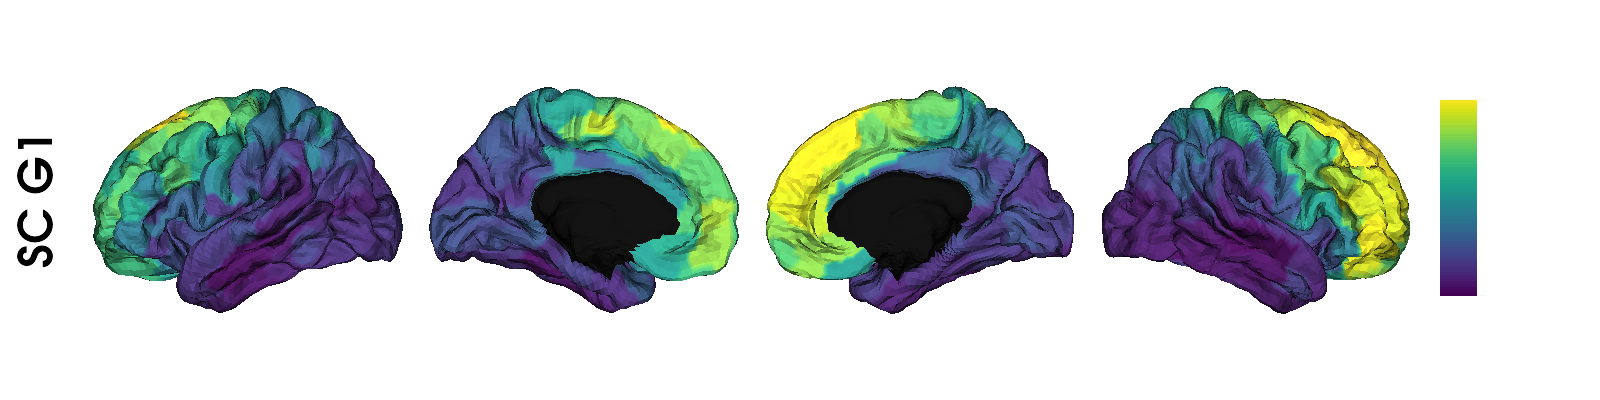

In [202]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    pial_left, pial_right, gradients_surface['Structural covariance'][:, 0], label_text=['SC G1'],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

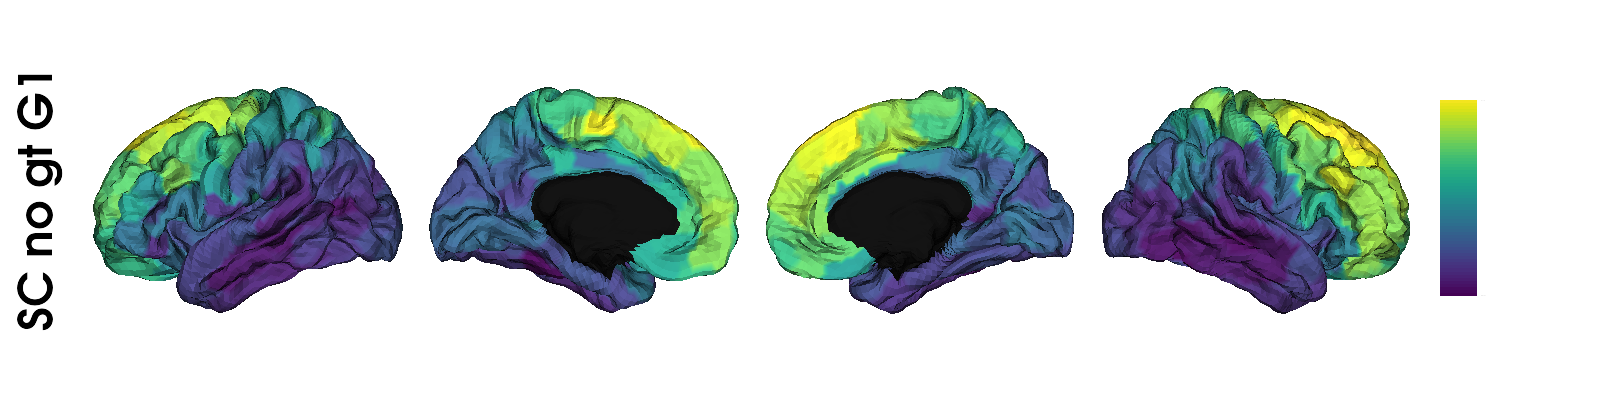

In [185]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    pial_left, pial_right, gradients_surface['Structural covariance (global thickness not regressed out)'][:, 0], 
    label_text=['SC no gt G1'],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

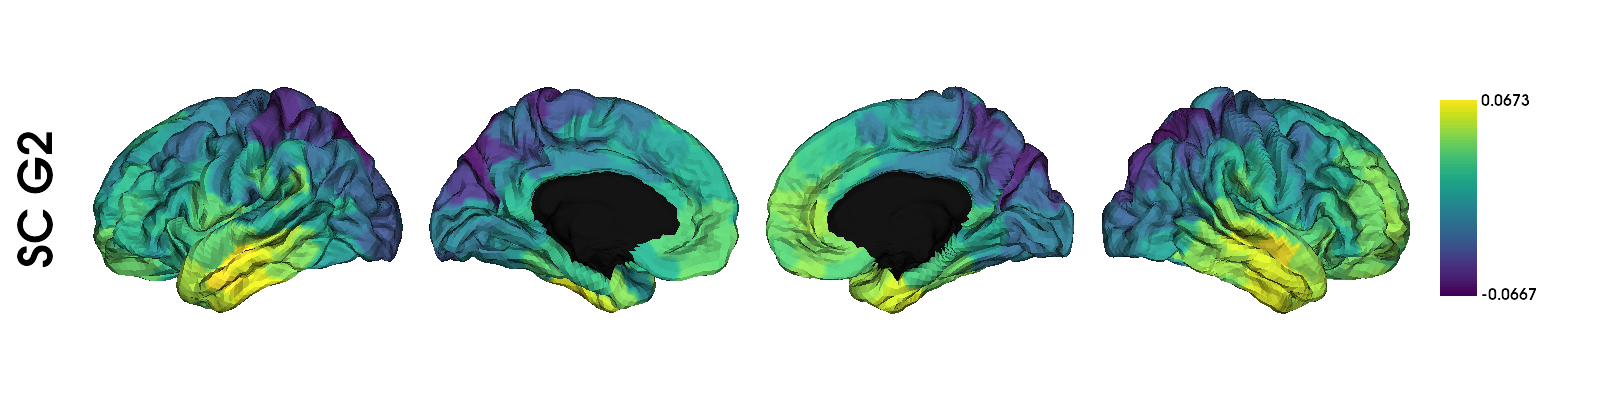

In [178]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    pial_left, pial_right, gradients_surface['Structural covariance'][:, 1], label_text=['SC G2'],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

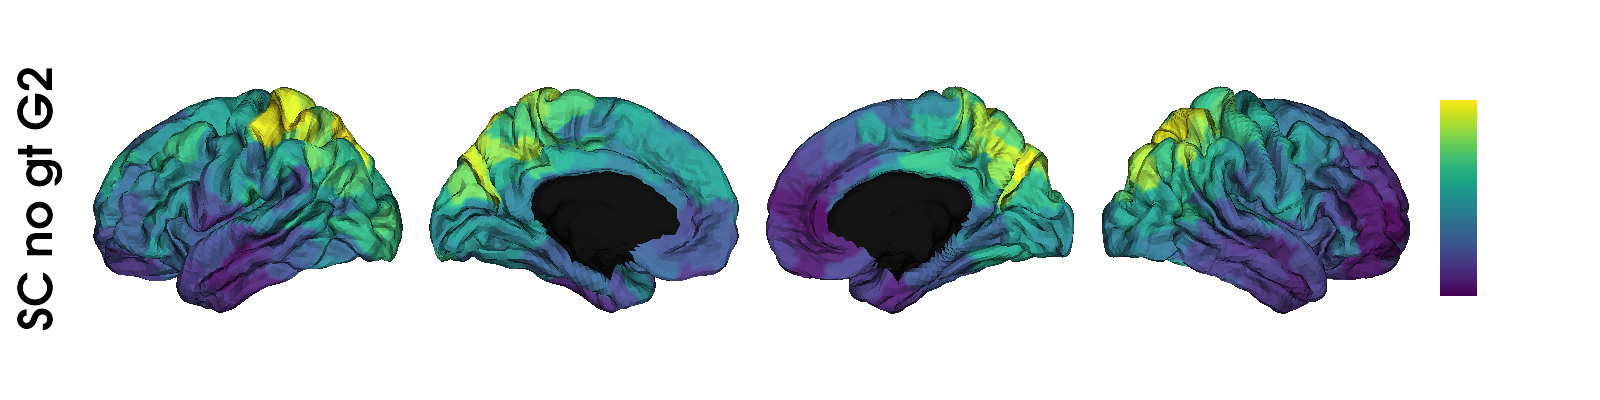

In [186]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    pial_left, pial_right, gradients_surface['Structural covariance (global thickness not regressed out)'][:, 1], 
    label_text=['SC no gt G2'],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

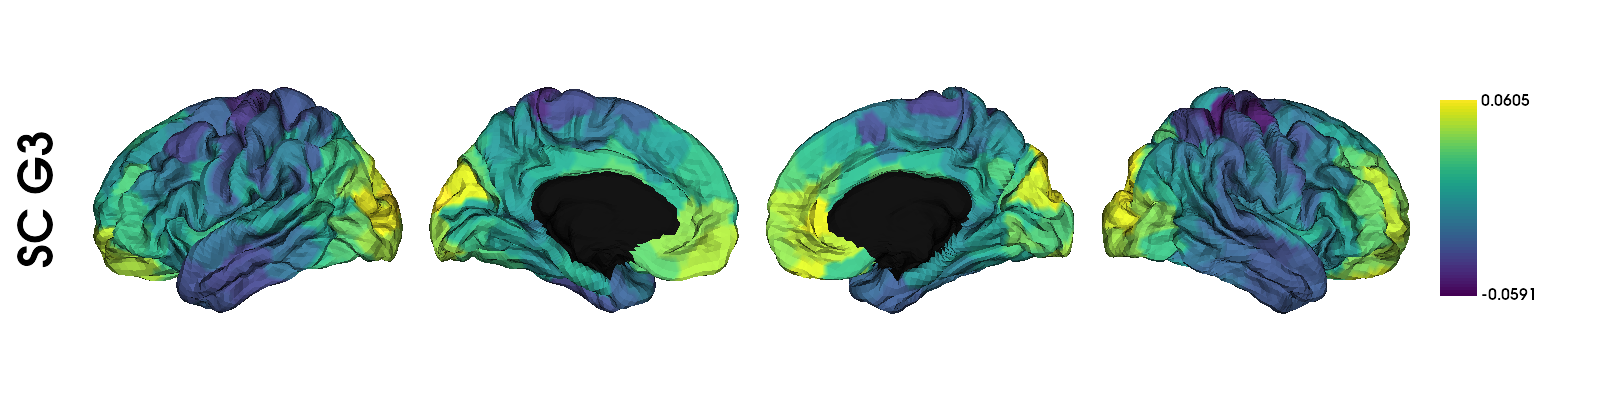

In [179]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    pial_left, pial_right, gradients_surface['Structural covariance'][:, 2], label_text=['SC G3'],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)

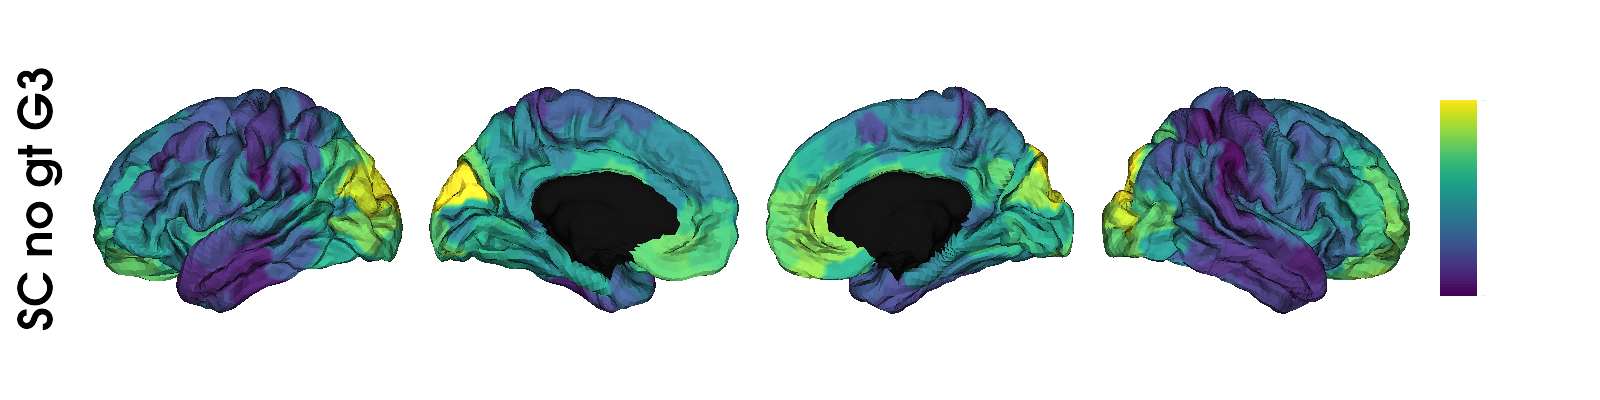

In [187]:
brainspace.plotting.surface_plotting.plot_hemispheres(
    pial_left, pial_right, gradients_surface['Structural covariance (global thickness not regressed out)'][:, 2], 
    label_text=['SC no gt G3'],
    color_bar=True, interactive=False, embed_nb=True, size=(1600, 400), zoom=1.2
)